# Car Price Prediction Pipeline — Expanded and Detailed Version

This notebook performs all the main steps of a machine learning project:

1. **Loading and initial inspection of the data**  
2. **Cleaning and handling of missing or inconsistent values**  
3. **Feature engineering**  
4. **Exploratory Data Analysis (EDA)**  
5. **Outlier treatment**  
6. **Final data preparation**  
7. **Building the machine learning pipeline**  
8. **Training and saving the model**  
9. **Inference with a new example**


In [36]:
# ==== Essential libraries ====
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

# ==== Scikit-learn core tools ====
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, MinMaxScaler, FunctionTransformer
)
from sklearn.model_selection import (
    train_test_split, RandomizedSearchCV
)
from sklearn.ensemble import (
    RandomForestRegressor, HistGradientBoostingRegressor, StackingRegressor
)
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score

# ==== Other utilities ====
from scipy.stats import uniform, randint
import joblib

# ==== Custom feature engineering ====
from feature_engineer import FeatureEngineer, add_features

# ==== Load and prepare dataset ====
file_path = 'new_vehicle_all_price.csv'
df = pd.read_csv(file_path)

# Filter out extreme price values
df = df[df['price'].between(2000, 150000)]

# Sample 1000 rows for faster development and consistent results
df = df.sample(n=1000, random_state=42).reset_index(drop=True)

# Show shape and preview
print(f"Shape: {df.shape}")
df.head()


Shape: (1000, 10)


,id,price,fuel,year,manufacturer,model,condition,odometer,transmission,paint_color
0,7312389600,5500,gas,1994,chevrolet,suburban 1500,NaN,117426,automatic,NaN
1,7309218331,29900,gas,2014,ford,f-150,excellent,114000,automatic,white
2,7315434677,3900,gas,2004,pontiac,grand am,NaN,149757,automatic,grey
3,7303628106,31800,gas,1996,ford,f-250 xlt 4x4,excellent,25850,automatic,NaN
4,7306950445,2900,gas,2007,ford,taurus,good,226274,automatic,blue


In [38]:
# ## 3) Renaming columns to standardize names used in the pipeline
rename_dict = {
    'manufacturer': 'make',         # Standardizing manufacturer name
    'fuel': 'fuel_type',            # Renaming to match feature name
    'odometer': 'Kilometer',        # Making odometer unit explicit
    'year': 'year',                 # No change but kept for consistency
    'price': 'Price'                # Capitalized for emphasis later
}
df.rename(columns=rename_dict, inplace=True)

# ## 4) Null value analysis and cleaning

# Display the count of missing values before handling them
print("\nMissing values before treatment:")
print(df.isnull().sum())



Missing values before treatment:
id                0
Price             0
fuel_type         5
year              0
make              0
model             0
condition       399
Kilometer         0
transmission      3
paint_color     294
dtype: int64


In [40]:
# Filling numeric columns with the median value (robust to outliers)
for col in ['Engine', 'Max Power']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Filling categorical columns with the most frequent value (mode)
for col in ['fuel_type', 'transmission', 'owner']:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0])

# Display the number of missing values after the treatment
print("\nMissing values after treatment:")
print(df.isnull().sum())



Missing values after treatment:
id                0
Price             0
fuel_type         0
year              0
make              0
model             0
condition       399
Kilometer         0
transmission      0
paint_color     294
dtype: int64



Distributions of numerical variables:


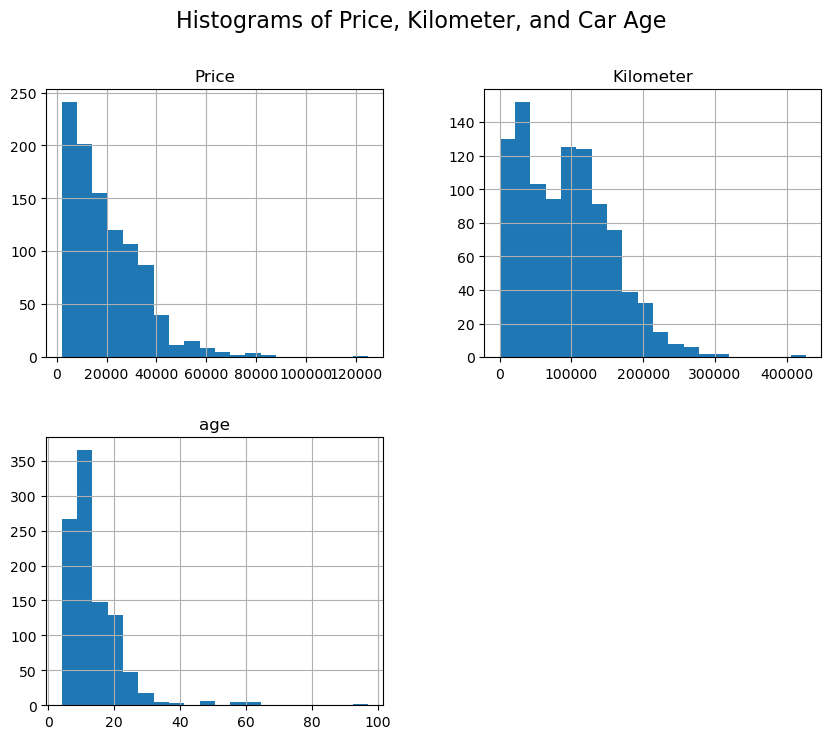

In [42]:
# ## 5) Visualization of numerical variable distributions

# Print label for context
print("\nDistributions of numerical variables:")

# Create a new feature: car age (current year minus year of manufacture)
df['age'] = datetime.datetime.now().year - df['year']

# Plot histograms for price, mileage, and age
# This helps understand data spread and detect skewness or outliers
df[['Price', 'Kilometer', 'age']].hist(
    bins=20,            # Number of histogram bins
    figsize=(10, 8)     # Size of the overall plot area
)
plt.suptitle("Histograms of Price, Kilometer, and Car Age", fontsize=16)
plt.show()


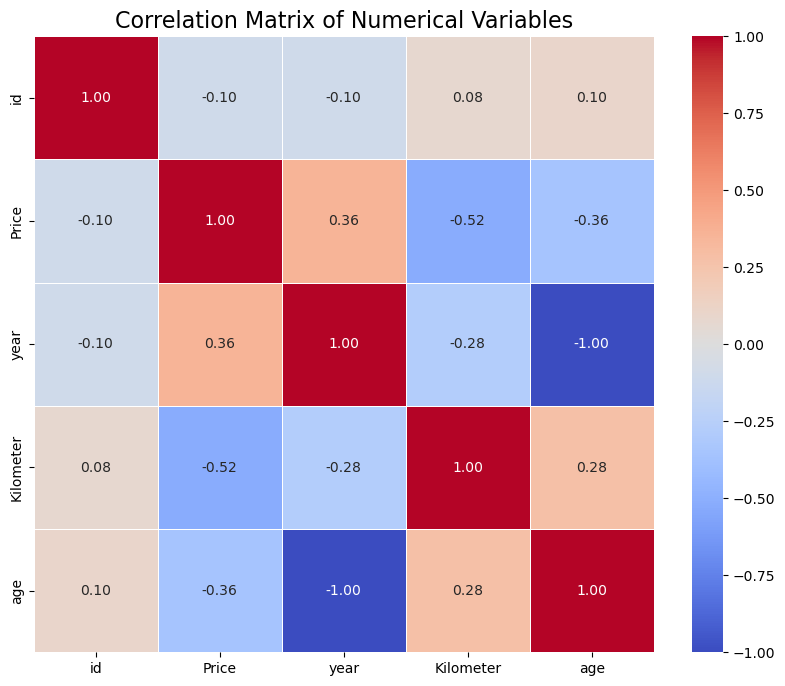

In [44]:
# ## 6) Correlation analysis between numerical variables

# Select all numeric columns from the dataset
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns

# Compute the correlation matrix to see linear relationships
correlation_matrix = df[numerical_columns].corr()

# Plotting the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,         # Show correlation coefficients inside the heatmap
    cmap='coolwarm',    # Color scale from blue (negative) to red (positive)
    fmt=".2f",          # Format correlation values with 2 decimal places
    linewidths=0.5      # Thin lines between cells for readability
)
plt.title("Correlation Matrix of Numerical Variables", fontsize=16)
plt.show()


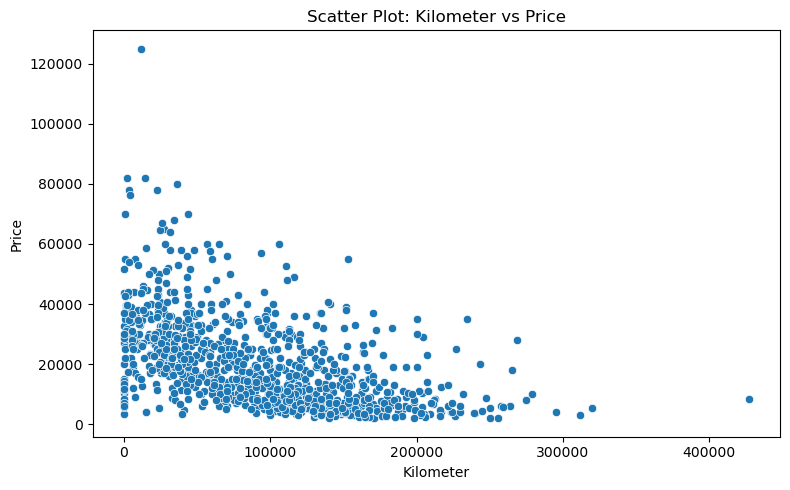

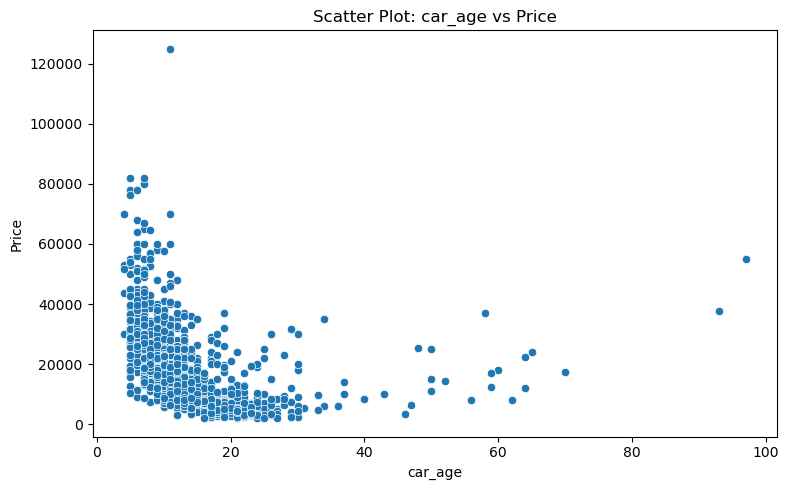

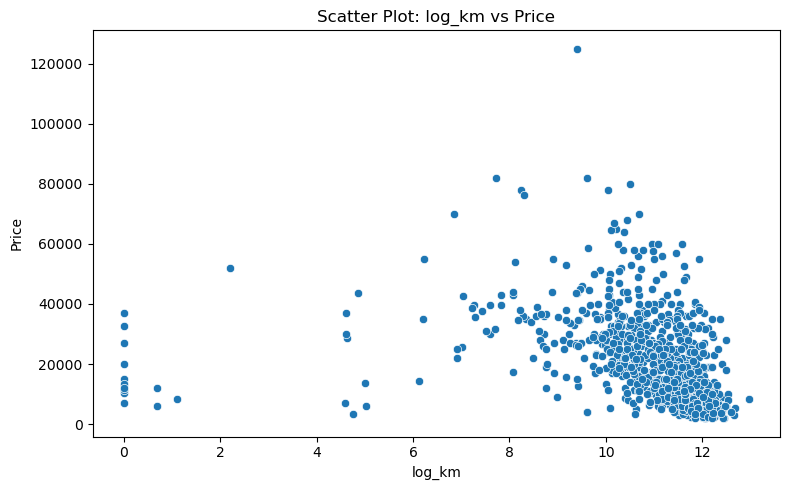

In [13]:
# ## 6.1) Scatter plots to visualize relationships between numerical variables and price

# Create derived features for better analysis
df['car_age'] = datetime.datetime.now().year - df['year']        # Age of the car
df['log_km'] = np.log1p(df['Kilometer'])                         # Log-transformed mileage
df['price_log'] = np.log1p(df['Price'])                          # Log-transformed price

# List of features to compare against Price
features_to_plot = ['Kilometer', 'car_age', 'log_km']

# Generate scatter plots to observe trends or patterns between features and price
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df[feature], y=df['Price'])
    plt.title(f"Scatter Plot: {feature} vs Price")               # Chart title
    plt.xlabel(feature)                                          # X-axis label
    plt.ylabel('Price')                                          # Y-axis label
    plt.tight_layout()
    plt.show()


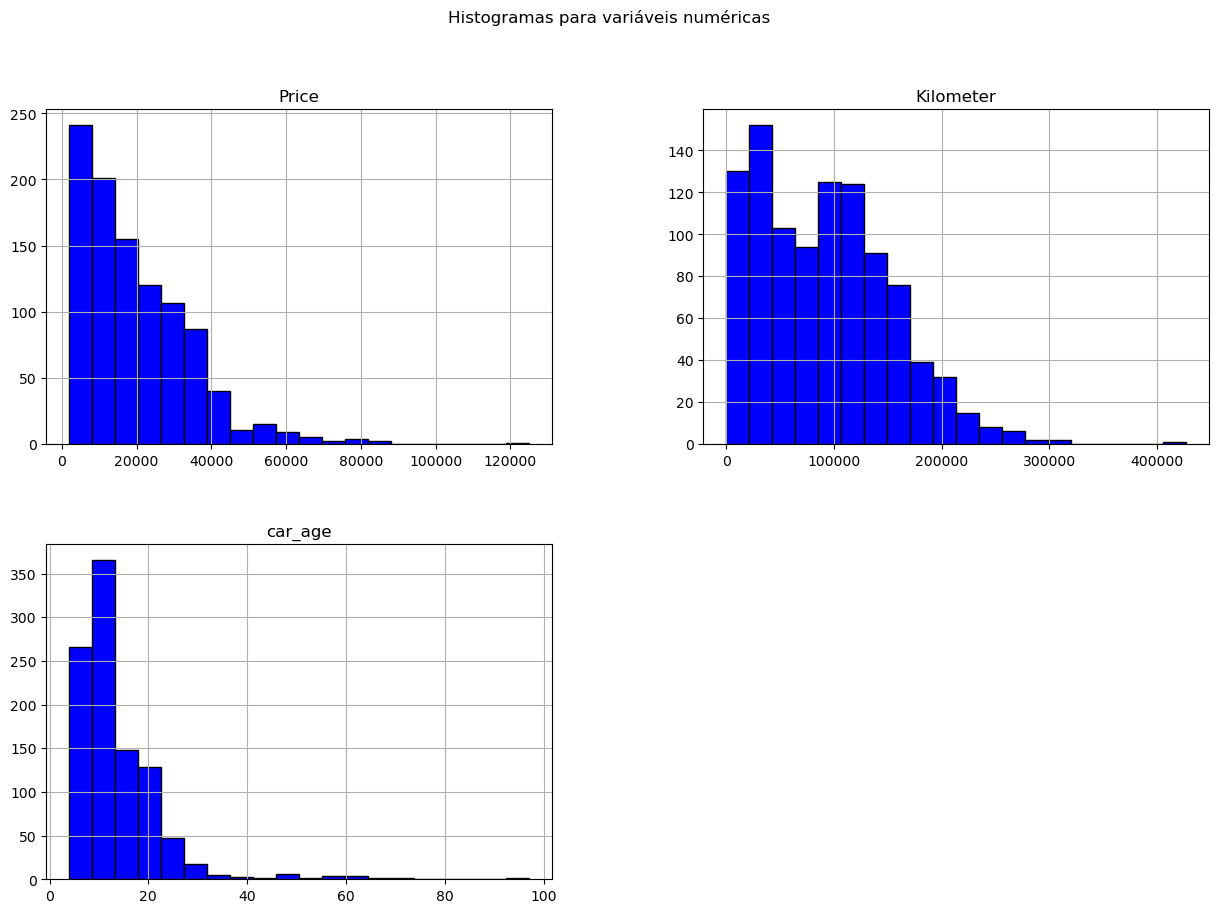

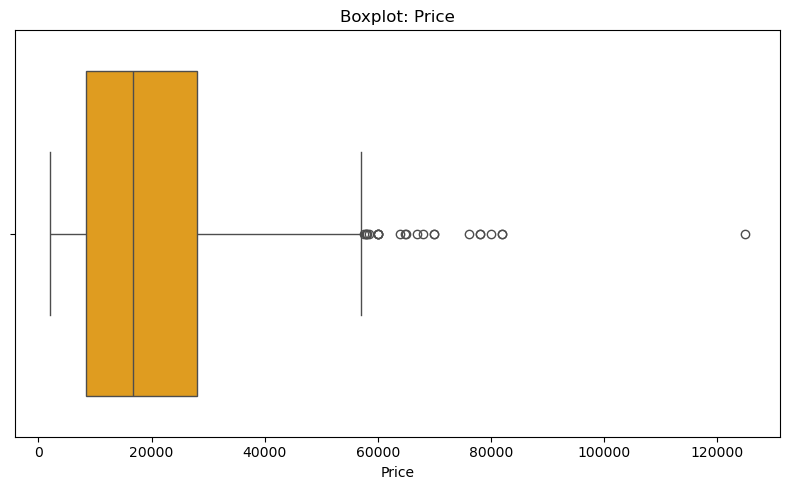

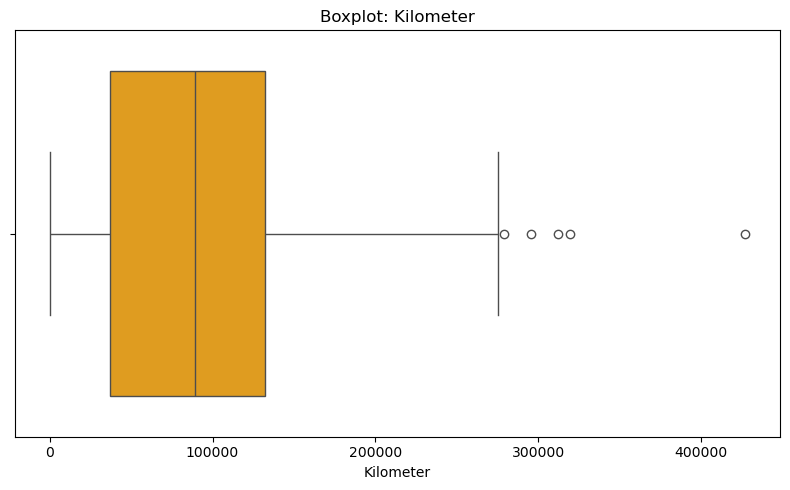

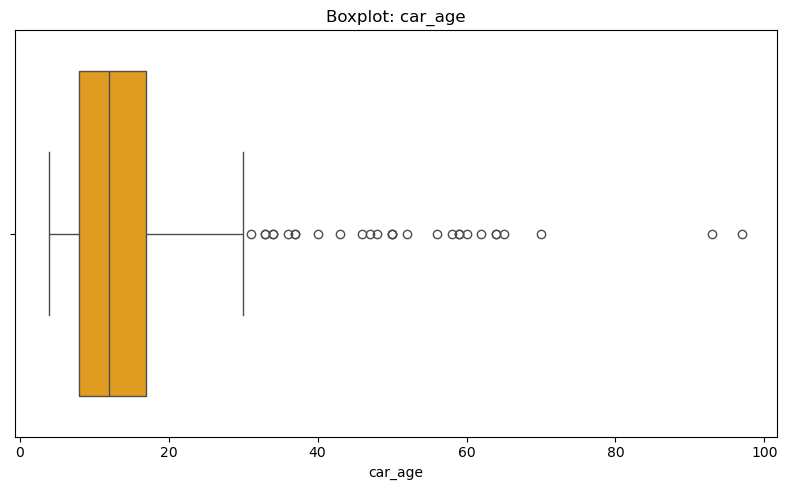

In [15]:
# ## 6.2) Histograms and boxplots for numerical variables

# Generate car age if not already in the DataFrame
if 'car_age' not in df.columns:
    df['car_age'] = datetime.datetime.now().year - df['year']

# Define a list of numerical features to visualize
numerical_features = ['Price', 'Kilometer', 'car_age']
if 'Engine' in df.columns:
    numerical_features.append('Engine')
if 'Max Power' in df.columns:
    numerical_features.append('Max Power')

# Plot histograms for each numerical feature
df[numerical_features].hist(
    bins=20, figsize=(15, 10), color='blue', edgecolor='black'
)
plt.suptitle("Histograms for Numerical Variables")
plt.show()

# Plot boxplots to detect outliers in each numerical feature
for feature in numerical_features:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=df[feature], color='orange')
    plt.title(f"Boxplot: {feature}")
    plt.tight_layout()
    plt.show()


In [48]:
# ## 7) Removing records with missing values in essential columns

# Define the list of essential columns required for modeling
col_required = ['make', 'model', 'fuel_type', 'transmission', 'Kilometer', 'year', 'Price']

# Drop any rows where at least one of the essential columns is missing
df.dropna(subset=col_required, inplace=True)


In [50]:
# ## 8) Data type conversion and removal of extreme outliers

# Convert key columns to numeric types, coercing errors to NaN
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Kilometer'] = pd.to_numeric(df['Kilometer'], errors='coerce')
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Remove entries with unrealistically low prices (e.g., below 1000)
df = df[df['Price'] >= 1000]


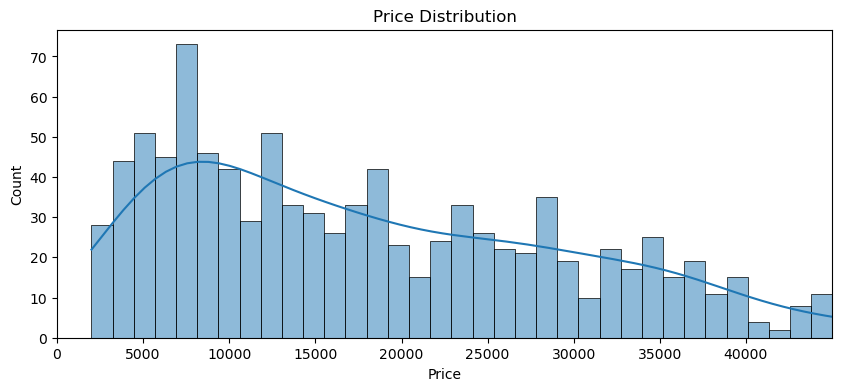

In [51]:
# ## 9) Visualization of price distribution (updated)

# Create a histogram of the Price column with a KDE curve
plt.figure(figsize=(10, 4))
sns.histplot(df['Price'], bins=100, kde=True)

# Set chart title and limit x-axis to the 95th percentile to reduce skew from outliers
plt.title("Price Distribution")
plt.xlim(0, df['Price'].quantile(0.95))

# Display the plot
plt.show()


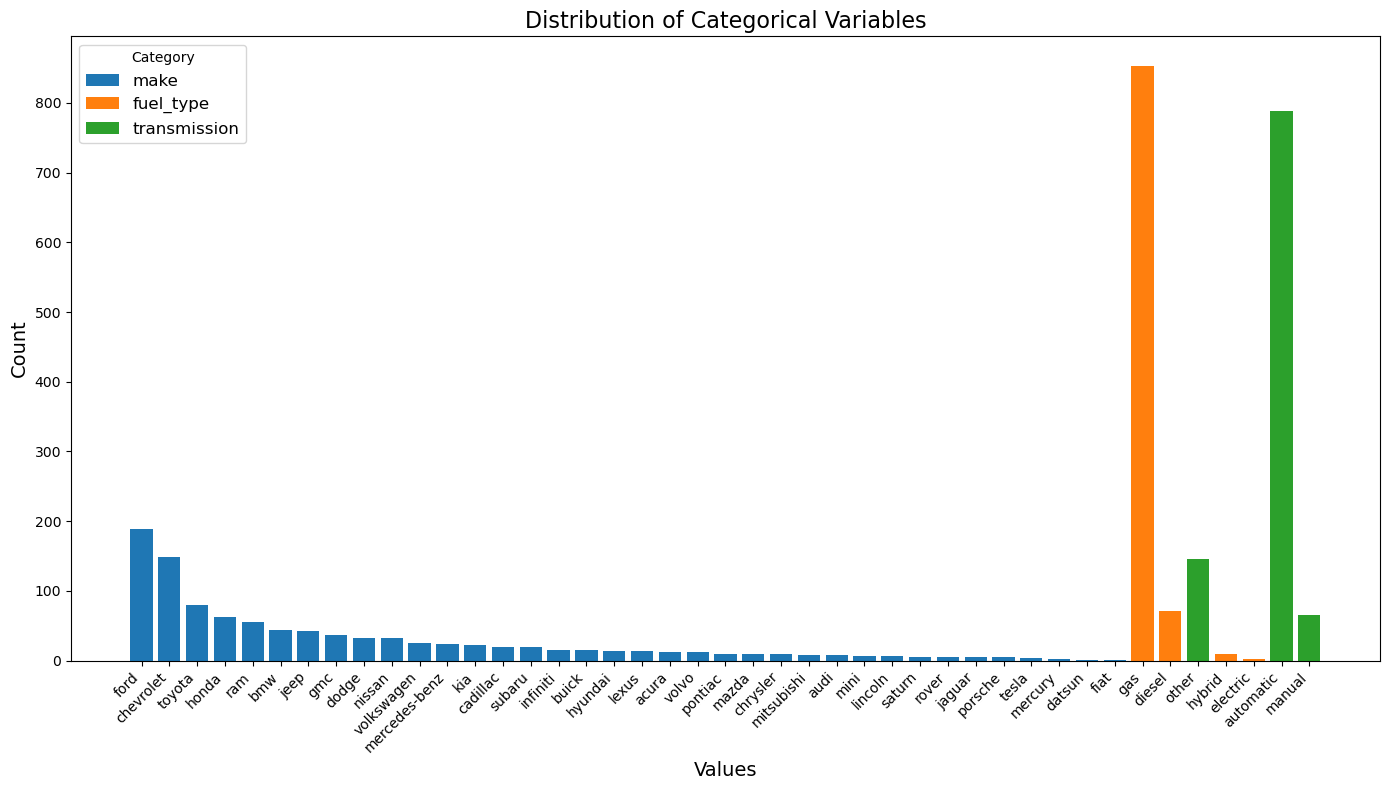

In [54]:
# ## 10) Visualization of categorical variable distributions

# Count occurrences for selected categorical features
categories = {
    'make': df['make'].value_counts(),
    'fuel_type': df['fuel_type'].value_counts(),
    'transmission': df['transmission'].value_counts()
}

# Combine all counts into a single DataFrame for plotting
combined_df = pd.concat(categories).reset_index()
combined_df.columns = ['Category', 'Value', 'Count']

# Plot a grouped bar chart showing distribution for each categorical variable
plt.figure(figsize=(14, 8))
for category in combined_df['Category'].unique():
    cat_data = combined_df[combined_df['Category'] == category]
    plt.bar(cat_data['Value'], cat_data['Count'], label=category)

# Customize plot appearance
plt.title("Distribution of Categorical Variables", fontsize=16)
plt.xlabel("Values", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend(title="Category", fontsize=12)
plt.tight_layout()
plt.show()


In [56]:
# === Feature Transformation ===
# Apply custom feature engineering (e.g., calculate car age, mileage per year, luxury flag)
feature_transform = FunctionTransformer(add_features)

# === Sampling and Feature-Target Split ===
# Randomly sample 500 rows for training (to reduce training time during prototyping)
sample_df = df.sample(n=500, random_state=42)

# Select relevant features and target variable
X = sample_df[['make', 'model', 'fuel_type', 'transmission', 'Kilometer', 'year']]
y = np.log1p(sample_df['Price'])  # Apply log transformation to reduce skewness

# Apply the custom transformation to enrich feature set
X = feature_transform.transform(X)

# === Train-Test Split ===
# Split data into training and testing sets (80% train, 20% test)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === Preprocessing Pipeline ===
# Define preprocessing: scale numerical features, one-hot encode categorical ones
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

cat_feats = ['make', 'model', 'fuel_type', 'transmission']              # Categorical features
num_feats = ['age', 'mileage_per_year', 'is_luxury_brand']              # Engineered numerical features

# Combine all preprocessing steps into a unified transformer
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_feats),                               # Normalize numerical data
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_feats)  # Encode categories
], sparse_threshold=0.3)

# === Base Model Pipelines ===
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

# Random Forest pipeline
rf = Pipeline([
    ('prep', preprocessor),
    ('model', RandomForestRegressor(random_state=42, n_jobs=-1))
])

# Histogram-based Gradient Boosting pipeline
gb = Pipeline([
    ('prep', preprocessor),
    ('model', HistGradientBoostingRegressor(random_state=42))
])

# === Hyperparameter Tuning ===
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameter space for Random Forest
rf_params = {
    'model__n_estimators': randint(150, 500),
    'model__max_depth': [None] + list(range(10, 25, 5)),
    'model__min_samples_split': randint(2, 10),
    'model__min_samples_leaf': randint(1, 5)
}

# Define hyperparameter space for Gradient Boosting
gb_params = {
    'model__learning_rate': uniform(0.01, 0.19),
    'model__max_iter': randint(150, 600),
    'model__max_depth': randint(4, 10)
}

# Perform randomized search with 3-fold CV for Random Forest
rf_search = RandomizedSearchCV(rf, rf_params, n_iter=10, cv=3,
                               scoring='neg_root_mean_squared_error',
                               random_state=42, n_jobs=-1, verbose=1)
rf_search.fit(X_train, y_train)

# Same for Gradient Boosting
gb_search = RandomizedSearchCV(gb, gb_params, n_iter=10, cv=3,
                               scoring='neg_root_mean_squared_error',
                               random_state=42, n_jobs=-1, verbose=1)
gb_search.fit(X_train, y_train)

# Retrieve best models from each search
best_rf = rf_search.best_estimator_
best_gb = gb_search.best_estimator_

# === Final Gradient Boosting Pipeline ===
# Rebuild GB pipeline with best parameters (to ensure it's serializable without nested objects)
gb_no_densify = Pipeline([
    ('prep', preprocessor),
    ('model', HistGradientBoostingRegressor(**best_gb.named_steps['model'].get_params()))
])

# === Model Stacking ===
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import StackingRegressor

# Combine best RF and GB models into a stacked ensemble with RidgeCV as the meta-model
stack = StackingRegressor(
    estimators=[('rf', best_rf), ('hgb', gb_no_densify)],
    final_estimator=RidgeCV(),
    n_jobs=-1
)

# Train the final stacked model
stack.fit(X_train, y_train)

# === Model Evaluation ===
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
test_preds = stack.predict(X_test)

# Compute RMSE and R² for performance assessment
rmse_test = np.sqrt(mean_squared_error(y_test, test_preds))
r2_test = r2_score(y_test, test_preds)

# Display best hyperparameters and evaluation metrics
print("Random Forest Best Params:", rf_search.best_params_)
print("HistGradientBoosting Best Params:", gb_search.best_params_)
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R²: {r2_test:.3f}")


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Random Forest Best Params: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 9, 'model__n_estimators': 443}
HistGradientBoosting Best Params: {'model__learning_rate': 0.021035886311957897, 'model__max_depth': 8, 'model__max_iter': 249}
Test RMSE: 0.46
Test R²: 0.626


In [58]:
import joblib

# === Final Pipeline Creation and Saving ===

# Combine feature engineering and the trained stacking model into a single pipeline
final_pipeline = Pipeline([
    ('feat_eng', feature_transform),  # Step 1: Apply custom feature transformations
    ('model', stack)                  # Step 2: Use the stacked ensemble model for prediction
])

# Save the complete pipeline to a .pkl file for future inference
joblib.dump(final_pipeline, 'car_price_stacked_pipeline.pkl', protocol=4)

print("Stacked model saved successfully!")


Stacked model saved successfully!


In [60]:
import joblib
import numpy as np
import pandas as pd

# === Sample Input for Inference ===
# Define a single car entry as a dictionary
sample = {
    'make': 'BMW',
    'model': 'i3',
    'fuel_type': 'electric',
    'transmission': 'automatic',
    'year': 2015,
    'Kilometer': 80000
}

# Convert the dictionary to a DataFrame (required input format for the pipeline)
df_s = pd.DataFrame([sample])

# === Load Trained Pipeline ===
# Load the full pipeline (feature engineering + stacked model)
loaded_model = joblib.load('car_price_stacked_pipeline.pkl')

# === Make Prediction ===
# Predict log(price), then reverse the log transformation to get the actual price
log_pred = loaded_model.predict(df_s)[0]
price_pred = np.expm1(log_pred)

# Display the final predicted price in Brazilian currency format
print(f"Predicted Price: R$ {price_pred:,.2f}")


Predicted Price: R$ 21,916.64


Top 10 features:
 age                   0.586258
mileage_per_year      0.205401
fuel_type_diesel      0.062219
fuel_type_gas         0.030352
make_chevrolet        0.015324
transmission_other    0.012900
make_ford             0.011887
make_nissan           0.008543
make_jeep             0.008248
make_ram              0.007375
dtype: float64


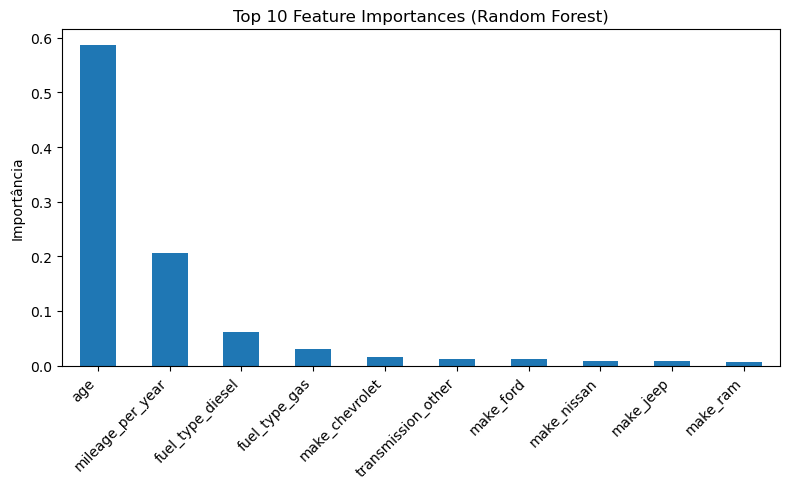

In [32]:
# Extrai nomes das features transformadas do best_rf
preproc = best_rf.named_steps['prep']
cat_names = list(preproc.named_transformers_['cat'].get_feature_names_out(cat_feats))
feature_names = num_feats + cat_names

# Importância das features no Random Forest
importances = best_rf.named_steps['model'].feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

# Exibe top 10
print("Top 10 features:\n", feat_imp.head(10))

# Plot
plt.figure(figsize=(8,5))
feat_imp.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.ylabel('Importância')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
